# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

**Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type**. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that **predicts how much someone will spend based on demographics and offer type**. Or you could build a model that **predicts whether or not someone will respond to an offer**. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Set Overview

- The program used to create the data simulates how people make purchasing decisions and how those decisions are influenced by promotional offers.
- Each person in the simulation has some hidden traits that influence their purchasing patterns and are associated with their observable traits. People produce various events, including receiving offers, opening offers, and making purchases.
- As a simplification, there are no explicit products to track. Only the amounts of each transaction or offer are recorded.
- There are three types of offers that can be sent: **buy-one-get-one (BOGO), discount, and informational**. In a BOGO offer, a user needs to spend a certain amount to get a reward equal to that threshold amount. In a discount, a user gains a reward equal to a fraction of the amount spent. In an informational offer, there is no reward, but neither is there a requisite amount that the user is expected to spend. Offers can be delivered via multiple channels.
- The basic task is to use the data to identify which groups of people are most responsive to each type of offer, and how best to present each type of offer.

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  


In [142]:
import pandas as pd
import numpy as np
import math
import json
import matplotlib.pyplot as plt
import seaborn as sns
import time

In [11]:
% matplotlib inline

UsageError: Line magic function `%` not found.


In [2]:
# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

# Data Exploration

### 1. Portfolio table: only 10 lines since it is the repository for the transaction type

In [3]:
portfolio.head(15)

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7
5,3,"[web, email, mobile, social]",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2
6,2,"[web, email, mobile, social]",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4
7,0,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837
8,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d
9,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5


In [40]:
portfolio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   reward      10 non-null     int64 
 1   channels    10 non-null     object
 2   difficulty  10 non-null     int64 
 3   duration    10 non-null     int64 
 4   offer_type  10 non-null     object
 5   id          10 non-null     object
dtypes: int64(3), object(3)
memory usage: 608.0+ bytes


### 2. Profile table : basic statistics and feature engineering of dates

In [4]:
profile.head()

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


In [5]:
profile.describe()

,age,became_member_on,income
count,17000.000000,1.700000e+04,14825.000000
mean,62.531412,2.016703e+07,65404.991568
std,26.738580,1.167750e+04,21598.299410
min,18.000000,2.013073e+07,30000.000000
25%,45.000000,2.016053e+07,49000.000000
50%,58.000000,2.017080e+07,64000.000000
75%,73.000000,2.017123e+07,80000.000000
max,118.000000,2.018073e+07,120000.000000


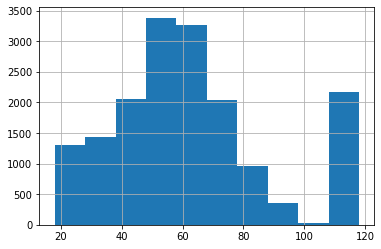

In [6]:
profile.age.hist();

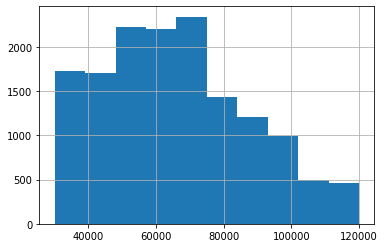

In [16]:
profile.income.hist();

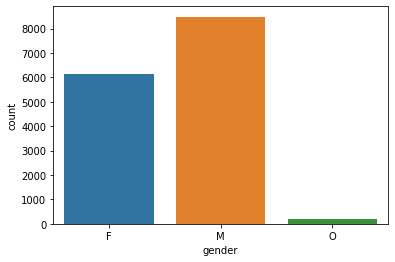

In [12]:
sns.countplot(x='gender', data=profile)

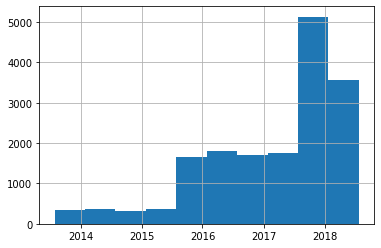

In [34]:
# Transform membership date into datetime
profile["date_member"]=pd.to_datetime(profile.became_member_on, format='%Y%m%d')
profile.date_member.hist()

In [35]:
# Transform date into a reusable feature: "time_since_member"
profile["time_since_member"]= profile.date_member.apply(lambda x: (pd.datetime.datetime.today().date()-x.date()))
profile.head()

,gender,age,id,became_member_on,income,date_member,time_since_member
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN,2017-02-12,1174 days
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0,2017-07-15,1021 days
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN,2018-07-12,659 days
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0,2017-05-09,1088 days
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN,2017-08-04,1001 days


### 3. Transcript table

In [39]:
transcript.head()

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


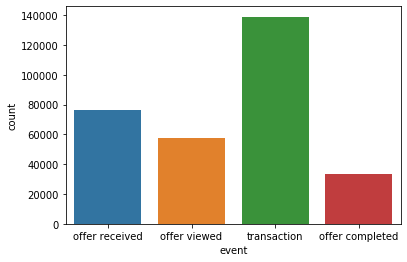

In [44]:
# Distribution of events
sns.countplot(x="event",data=transcript);

print("offer received: -----------------------------------")
print(transcript[transcript.event=="offer received"].head(2)) #'offer id'
print("offer viewed: -----------------------------------")
print(transcript[transcript.event=="offer viewed"].head(2)) #'offer id'
print("offer completed: -----------------------------------")
print(transcript[transcript.event=="offer completed"].head(2)) #'offer_id'
print("transaction: -----------------------------------")
print(transcript[transcript.event=="transaction"].head(2)) # 'amount'

In [131]:
# Feature Engineering of the value colum
def feature_column_offer_id(x):
    value = 0
    if "offer id" in x:
        value = x["offer id"]
    if "offer_id" in x:
        value = x["offer_id"]
    return value

def feature_column_amount(x):
    value = np.nan
    if "amount" in x:
        value = x["amount"]
    return value

transcript["offer_id"] = transcript["value"].apply(lambda x: feature_column_offer_id(x))
transcript["amount_spent"] = transcript["value"].apply(lambda x: feature_column_amount(x))

#transcript.drop(labels =["value"],axis=1)
transcript.head()

,person,event,value,time,offer_id,amount_spent
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0,2906b810c7d4411798c6938adc9daaa5,NaN
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0,fafdcd668e3743c1bb461111dcafc2a4,NaN
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN


In [63]:
# Analysis of the offer
transcript.event.value_counts().index
offer_analysis = dict(zip(transcript.event.value_counts().index.tolist(),transcript.event.value_counts().values.tolist()))

transaction_viewed_pct = round(offer_analysis["offer viewed"]/offer_analysis["offer received"],2)
print("The share of offer viewed amnong the offer recieved is of {} %".format(transaction_viewed_pct*100))

transaction_completed_pct = round(offer_analysis["offer completed"]/offer_analysis["offer received"],2)
print("The share of offer completed amnong the offer recieved is of {} %".format(transaction_completed_pct*100))

The share of offer viewed amnong the offer recieved is of 76.0 %
The share of offer completed amnong the offer recieved is of 44.0 %


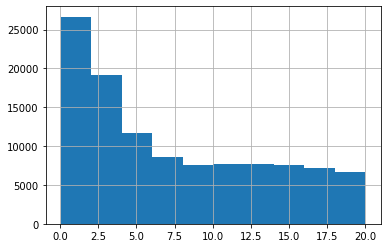

In [138]:
# Amount spent below 20 (since a maximum value above 1,000)
transcript["amount_spent"].loc[transcript.amount_spent<20].hist() 

## Feature Engineering to understand a user behavior

In [326]:
transcript.person.nunique()

17000

In [332]:
# Statistics per user
transcript.groupby('person').count()["offer_id"]

person
0009655768c64bdeb2e877511632db8f    20
00116118485d4dfda04fdbaba9a87b5c     7
0011e0d4e6b944f998e987f904e8c1e5    18
0020c2b971eb4e9188eac86d93036a77    19
0020ccbbb6d84e358d3414a3ff76cffd    23
                                    ..
fff3ba4757bd42088c044ca26d73817a    23
fff7576017104bcc8677a8d63322b5e1    18
fff8957ea8b240a6b5e634b6ee8eafcf    10
fffad4f4828548d1b5583907f2e9906b    23
ffff82501cea40309d5fdd7edcca4a07    33
Name: offer_id, Length: 17000, dtype: int64

In [606]:
def extract_promo_information_and_related_transactions(transcript,user_id):
    '''
    Goal: for a given person, understand the different promotion lifecyle and how they are related to existing transactions
    Input:
    - transcript (dataframe): dataframe of the transactions
    - user_id (string): person to be considered
    Output:
    - offer_life_cycle_final (dataframe): for each cretaed promotion, follow its lifecycle by indicating if it has been viewed, and/or completed
    - transaction_id_full (dataframe): same dataframe as transcript, enriched by the associated promotion of each transaction if it exists

    '''
    # Get the transaction of a given user_id
    transaction_id = transcript[transcript.person ==user_id].drop(labels=['value'],axis=1)

    # Merge with transaction informations
    transaction_id_full = pd.merge(transaction_id,portfolio, left_on="offer_id",right_on="id", how="left").drop(labels=["channels","id"],axis=1)

    # Enrich the transaction table with connected promotions and their respective information 
    transaction_id_full["linked_promo"]=0 # 0 by default, 1 if a promotion has been seen and has been followed by a transaction in the duration period
    transaction_id_full["creation_time"]=0
    transaction_id_full["expiration_time"]=0

    # Instanciate the three dataframe following promotion lifecycles
    dict_time_offer_received =pd.DataFrame({
        "offer_id":[],
        "creation_time":[],
        "expiration_time":[]
    })

    dict_time_offer_viewed =pd.DataFrame({
        "offer_id":[],
        "creation_time":[],
        "time":[],
        "expiration_time":[]
    })

    dict_time_offer_completed =pd.DataFrame({
        "offer_id":[],
        "time":[],
        "expiration_time":[]
    })

    # Instantiate the liste to follow the promotion that have been seen and completed already
    offer_completed =[]

    # Iteration over each transaction line
    for i,v in transaction_id_full.iterrows():

         # Append the dict_time_offer_received dataframe with the offer received information
        if v["event"]=="offer received":
            dict_time_offer_received = dict_time_offer_received.append({'offer_id':v["offer_id"],'creation_time':v["time"],"expiration_time":(v["time"]+int(v["duration"]*24))},ignore_index=True)
        
        # Append the dict_time_offer_received dataframe with the offer viewed information
        if v["event"]=="offer viewed":
            
            offer_id = v["offer_id"]
            creation_time = dict_time_offer_received[dict_time_offer_received.offer_id==offer_id]["creation_time"].iloc[-1]
            expiration_time = dict_time_offer_received[dict_time_offer_received.offer_id==offer_id]["expiration_time"].iloc[-1]
            dict_time_offer_viewed = dict_time_offer_viewed.append({'offer_id':offer_id,'creation_time':creation_time,"time":v["time"],"expiration_time":expiration_time},ignore_index=True)

            # Rule: To take into account the case when an offer is repushed and reviewed, we need to reset the offer_completed liste (and therefore to erase the corresponding value in offer_completed)
            if offer_id in offer_completed :
                offer_completed = np.setdiff1d(offer_completed,offer_id,assume_unique=True).tolist()
        
        # Append the dict_time_offer_received dataframe with the offer completed information
        if v["event"]=="offer completed":
            offer_id = v["offer_id"]
            creation_time = dict_time_offer_received[dict_time_offer_received.offer_id==offer_id]["creation_time"].iloc[-1]
            expiration_time = dict_time_offer_received[dict_time_offer_received.offer_id==offer_id]["expiration_time"].iloc[-1]
            dict_time_offer_completed = dict_time_offer_completed.append({'offer_id':offer_id,'creation_time':creation_time,"time":v["time"],"expiration_time":expiration_time},ignore_index=True)

            # Append the liste with the completed offer
            offer_completed.append(v["offer_id"])
        
         # Affect promotions that have been seen and not completed yet to transactions
        if v["event"]=="transaction":
            # Rule 1: An promotion is affected to a transaction ("is_trans_promo_driven") only if it has not been completed yet.
            # Rule 2: If two promotions have been viewed and not completed yet, we consider that only the last transaction
            
            # Check that dict_time_offer_viewed is non null
            if dict_time_offer_viewed.shape[0]>0 :
                is_transaction_promotion_driven = dict_time_offer_viewed[(dict_time_offer_viewed["expiration_time"]>= v["time"]) & (v["time"]>=dict_time_offer_viewed["creation_time"])]
                
                #Check that is_transaction_promotion_driven is non null
                if is_transaction_promotion_driven.shape[0]>0:
                    is_transaction_promotion_driven_without_completed = np.setdiff1d(is_transaction_promotion_driven.offer_id,offer_completed,assume_unique=True).tolist()
                    if len(is_transaction_promotion_driven_without_completed)>0:
                        linked_promo_id = is_transaction_promotion_driven_without_completed[-1]
                        transaction_id_full.loc[i,"linked_promo"]= linked_promo_id
                        transaction_id_full.loc[i,"creation_time"]= is_transaction_promotion_driven[is_transaction_promotion_driven.offer_id ==linked_promo_id]["creation_time"].iloc[-1]
                        transaction_id_full.loc[i,"expiration_time"]= is_transaction_promotion_driven[is_transaction_promotion_driven.offer_id ==linked_promo_id]["expiration_time"].iloc[-1]
            
                
    # Build the life cycle of every promotion using the unique key [offer_id,creation_time,expiration_time]
    dict_time_offer_viewed["is_viewed"]=1
    dict_time_offer_completed["is_completed"]=1

    # Distinct all the different cases
    if (dict_time_offer_received.shape[0]>0)&(dict_time_offer_viewed.shape[0]>0)&(dict_time_offer_completed.shape[0]>0):
        offer_life_cycle1 = pd.merge(dict_time_offer_received,dict_time_offer_viewed,on=["offer_id","creation_time","expiration_time"],how='left').drop(labels=["time"],axis=1)
        offer_life_cycle_final = pd.merge(offer_life_cycle1,dict_time_offer_completed,on=["offer_id","creation_time","expiration_time"],how='left').drop(labels=["time"],axis=1)           
    else :
        offer_life_cycle_final = pd.DataFrame()
    
    return offer_life_cycle_final,transaction_id_full

In [588]:
def extract_promo_information_and_related_transactions_new(transcript,user_id):
    '''
    Goal: for a given person, understand the different promotion lifecyle and how they are related to existing transactions
    Input:
    - transcript (dataframe): dataframe of the transactions
    - user_id (string): person to be considered
    Output:
    - offer_life_cycle_final (dataframe): for each cretaed promotion, follow its lifecycle by indicating if it has been viewed, and/or completed
    - transaction_id_full (dataframe): same dataframe as transcript, enriched by the associated promotion of each transaction if it exists

    '''
    # Get the transaction of a given user_id
    transaction_id = transcript[transcript.person ==user_id].drop(labels=['value'],axis=1)

    # Merge with transaction informations
    transaction_id_full = pd.merge(transaction_id,portfolio, left_on="offer_id",right_on="id", how="left").drop(labels=["channels","id"],axis=1)

    # Enrich the transaction table with connected promotions and their respective information 
    transaction_id_full["linked_promo"]=0 # 0 by default, 1 if a promotion has been seen and has been followed by a transaction in the duration period
    transaction_id_full["creation_time"]=0
    transaction_id_full["expiration_time"]=0

    # Instanciate the three dataframe following promotion lifecycles
    dict_time_offer_received =pd.DataFrame({
        "offer_id":[],
        "creation_time":[],
        "expiration_time":[]
    })

    dict_time_offer_viewed =pd.DataFrame({
        "offer_id":[],
        "creation_time":[],
        "time":[],
        "expiration_time":[]
    })

    dict_time_offer_completed =pd.DataFrame({
        "offer_id":[],
        "time":[],
        "expiration_time":[]
    })

    # Instantiate the liste to follow the promotion that have been seen and completed already
    offer_completed =[]

    # Iteration over each transaction line
    for i,v in transaction_id_full.iterrows():

         # Append the dict_time_offer_received dataframe with the offer received information
        if v["event"]=="offer received":
            dict_time_offer_received = dict_time_offer_received.append({'offer_id':v["offer_id"],'creation_time':v["time"],"expiration_time":(v["time"]+int(v["duration"]*24))},ignore_index=True)
        
        # Append the dict_time_offer_received dataframe with the offer viewed information
        if v["event"]=="offer viewed":
            
            offer_id = v["offer_id"]
            creation_time = dict_time_offer_received[dict_time_offer_received.offer_id==offer_id]["creation_time"].iloc[-1]
            expiration_time = dict_time_offer_received[dict_time_offer_received.offer_id==offer_id]["expiration_time"].iloc[-1]
            dict_time_offer_viewed = dict_time_offer_viewed.append({'offer_id':offer_id,'creation_time':creation_time,"time":v["time"],"expiration_time":expiration_time},ignore_index=True)

            # Rule: To take into account the case when an offer is repushed and reviewed, we need to reset the offer_completed liste (and therefore to erase the corresponding value in offer_completed)
            if offer_id in offer_completed :
                offer_completed = np.setdiff1d(offer_completed,offer_id,assume_unique=True).tolist()
        
        # Append the dict_time_offer_received dataframe with the offer completed information
        if v["event"]=="offer completed":
            offer_id = v["offer_id"]
            creation_time = dict_time_offer_received[dict_time_offer_received.offer_id==offer_id]["creation_time"].iloc[-1]
            expiration_time = dict_time_offer_received[dict_time_offer_received.offer_id==offer_id]["expiration_time"].iloc[-1]
            dict_time_offer_completed = dict_time_offer_completed.append({'offer_id':offer_id,'creation_time':creation_time,"time":v["time"],"expiration_time":expiration_time},ignore_index=True)

            # Append the liste with the completed offer
            offer_completed.append(v["offer_id"])
        
         # Affect promotions that have been seen and not completed yet to transactions
        if v["event"]=="transaction":
            # Rule 1: An promotion is affected to a transaction ("is_trans_promo_driven") only if it has not been completed yet.
            # Rule 2: If two promotions have been viewed and not completed yet, we consider that only the last transaction
            
            # Check that dict_time_offer_viewed is non null
            if dict_time_offer_viewed.shape[0]>0 :
                is_transaction_promotion_driven = dict_time_offer_viewed[(dict_time_offer_viewed["expiration_time"]>= v["time"]) & (v["time"]>=dict_time_offer_viewed["creation_time"])]
                
                #Check that is_transaction_promotion_driven is non null
                if is_transaction_promotion_driven.shape[0]>0:
                    is_transaction_promotion_driven_without_completed = np.setdiff1d(is_transaction_promotion_driven.offer_id,offer_completed,assume_unique=True).tolist()
                    if len(is_transaction_promotion_driven_without_completed)>0:
                        linked_promo_id = is_transaction_promotion_driven_without_completed[-1]
                        transaction_id_full.loc[i,"linked_promo"]= linked_promo_id
                        transaction_id_full.loc[i,"creation_time"]= is_transaction_promotion_driven[is_transaction_promotion_driven.offer_id ==linked_promo_id]["creation_time"].iloc[-1]
                        transaction_id_full.loc[i,"expiration_time"]= is_transaction_promotion_driven[is_transaction_promotion_driven.offer_id ==linked_promo_id]["expiration_time"].iloc[-1]
            
                
    # Build the life cycle of every promotion using the unique key [offer_id,creation_time,expiration_time]
    dict_time_offer_viewed["is_viewed"]=1
    dict_time_offer_completed["is_completed"]=1

    # Distinct all the different cases
    if (dict_time_offer_received.shape[0]>0):
        if (dict_time_offer_viewed.shape[0]>0):
            offer_life_cycle1 = pd.merge(dict_time_offer_received,dict_time_offer_viewed,on=["offer_id","creation_time","expiration_time"],how='left').drop(labels=["time"],axis=1)
        if (dict_time_offer_completed.shape[0]>0) :
            offer_life_cycle_2 = pd.merge(dict_time_offer_received,dict_time_offer_completed,on=["offer_id","creation_time","expiration_time"],how='left').drop(labels=["time"],axis=1)           
        if (dict_time_offer_viewed.shape[0]>0) & (dict_time_offer_completed.shape[0]>0):    
            offer_life_cycle_final = pd.merge(offer_life_cycle1,offer_life_cycle_2,on=["offer_id","creation_time","expiration_time"],how='outer').drop(labels=["time"],axis=1)           

    else :
        offer_life_cycle_final = pd.DataFrame()
        
    return offer_life_cycle_final,transaction_id_full

In [612]:
def final_promotion_lifecycle(offer_life_cycle_final,transaction_id_full,user_id):
    '''
    For a given person, get the final lifecycle dataframe building the lifecycle of every promotion and the associated amount spent
    Input :
    - user_id (string): person to be considered
    - offer_life_cycle_final (dataframe): for each cretaed promotion, follow its lifecycle by indicating if it has been viewed, and/or completed
    - transaction_id_full (dataframe): same dataframe as transcript, enriched by the associated promotion of each transaction if it exists
    Output :
    - offer_life_cycle_final_all: same as offer_life_cycle_final, enriched by the transaction amount (mean and total), and append with the 0 promotion
    
    '''
    # Extract relevant columns from the transaction_id_full dataframe
    transaction_id_full_extract = transaction_id_full[["amount_spent","linked_promo","creation_time","expiration_time"]].rename(columns= {"linked_promo":"offer_id"})
    
    # Consolidate average amount and total amount spent for each promotion (the promotion equal to 0 being the one not related to any promotions)
    transaction_id_full_extract_mean = transaction_id_full_extract.groupby(["offer_id","creation_time","expiration_time"])["amount_spent"].mean()
    transaction_id_full_extract_sum = transaction_id_full_extract.groupby(["offer_id","creation_time","expiration_time"])["amount_spent"].sum()

    transaction_id_full_extract_mean1= pd.DataFrame(transaction_id_full_extract_mean).reset_index().rename(columns={"amount_spent":"mean_amount_spent"})
    transaction_id_full_extract_sum1= pd.DataFrame(transaction_id_full_extract_sum).reset_index().rename(columns={"amount_spent":"total_amount_spent"})
    transaction_id_full_extract_amount_spent = pd.merge(transaction_id_full_extract_mean1,transaction_id_full_extract_sum1,on=["offer_id","creation_time","expiration_time"],how="inner")
   
    # Append the 0 promotion (i.e. the one not related to any promotion) to the lifecyle promotion
    offer_life_cycle_final_1 = offer_life_cycle_final.append({'offer_id':0,'creation_time':0.0,"expiration_time":0.0,"is_viewed":np.nan,"is_completed":np.nan},ignore_index=True)

    # Merge the lifecycle promotion dataframe with the corresponding amount transaction
    offer_life_cycle_final_all =pd.merge(offer_life_cycle_final_1,transaction_id_full_extract_amount_spent,on=["offer_id","creation_time","expiration_time"],how='left')
    
    # Check that all the amounts are correct
    ##assert abs((offer_life_cycle_final_all.total_amount_spent.sum()-transaction_id_full.amount_spent.sum())/transaction_id_full.amount_spent.sum())<0.10,"Oops there is a problem"
    return offer_life_cycle_final_all
    

In [502]:
transcript.groupby('person').count()["event"].sort_values(ascending=False)

person
94de646f7b6041228ca7dec82adb97d2    51
8dbfa485249f409aa223a2130f40634a    49
79d9d4f86aca4bed9290350fb43817c2    48
d0a80415b84c4df4908b8403b19765e3    48
5e60c6aa3b834e44b822ea43a3efea26    48
                                    ..
22617705eec442e0b7b43e5c5f56fb17     2
df9fc9a86ca84ef5aedde8925d5838ba     2
3a4e53046c544134bb1e7782248631d1     2
e63e42480aae4ede9f07cac49c8c3f78     2
da7a7c0dcfcb41a8acc7864a53cf60fb     1
Name: event, Length: 17000, dtype: int64

In [586]:
transcript[transcript.person=="7bdde8f906304a2f8c497f9d7474d8bd"].head(10)

,person,event,value,time,offer_id,amount_spent
7915,7bdde8f906304a2f8c497f9d7474d8bd,offer received,{'offer id': 'ae264e3637204a6fb9bb56bc8210ddfd'},0,ae264e3637204a6fb9bb56bc8210ddfd,NaN
17185,7bdde8f906304a2f8c497f9d7474d8bd,offer viewed,{'offer id': 'ae264e3637204a6fb9bb56bc8210ddfd'},6,ae264e3637204a6fb9bb56bc8210ddfd,NaN
110459,7bdde8f906304a2f8c497f9d7474d8bd,transaction,{'amount': 0.28},330,0,0.28
118745,7bdde8f906304a2f8c497f9d7474d8bd,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},336,2906b810c7d4411798c6938adc9daaa5,NaN
134269,7bdde8f906304a2f8c497f9d7474d8bd,transaction,{'amount': 1.01},354,0,1.01
158570,7bdde8f906304a2f8c497f9d7474d8bd,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},408,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN
176199,7bdde8f906304a2f8c497f9d7474d8bd,transaction,{'amount': 0.23},426,0,0.23
209491,7bdde8f906304a2f8c497f9d7474d8bd,offer received,{'offer id': '3f207df678b143eea3cee63160fa8bed'},504,3f207df678b143eea3cee63160fa8bed,NaN
238630,7bdde8f906304a2f8c497f9d7474d8bd,offer viewed,{'offer id': '3f207df678b143eea3cee63160fa8bed'},552,3f207df678b143eea3cee63160fa8bed,NaN
238631,7bdde8f906304a2f8c497f9d7474d8bd,transaction,{'amount': 0.24},552,0,0.24


In [617]:
user_id = "da7a7c0dcfcb41a8acc7864a53cf60fb"

In [618]:
offer_life_cycle_final,transaction_id_full = extract_promo_information_and_related_transactions(transcript,user_id)
offer_life_cycle_final.head()

""


In [578]:
#offer_life_cycle_final,transaction_id_full = extract_promo_information_and_related_transactions_new(transcript,user_id_init)

In [609]:
# Initialization
user_id_init = "94de646f7b6041228ca7dec82adb97d2"
offer_life_cycle_final,transaction_id_full = extract_promo_information_and_related_transactions(transcript,user_id_init)
offer_life_cycle_final_all = final_promotion_lifecycle(offer_life_cycle_final,transaction_id_full,user_id_init)
user_promotion_cycle = offer_life_cycle_final_all

In [610]:
user_promotion_cycle.head()

,offer_id,creation_time,expiration_time,is_viewed,is_completed,mean_amount_spent,total_amount_spent
0,f19421c1d4aa40978ebb69ca19b0e20d,0.0,120.0,1.0,1.0,7.410,7.41
1,9b98b8c7a33c4b65b9aebfe6a799e6d9,168.0,336.0,1.0,1.0,2.795,16.77
2,0b1e1539f2cc45b7b9fa7c272da2e1d7,336.0,576.0,NaN,1.0,NaN,NaN
3,fafdcd668e3743c1bb461111dcafc2a4,408.0,648.0,1.0,1.0,5.505,11.01
4,9b98b8c7a33c4b65b9aebfe6a799e6d9,504.0,672.0,1.0,1.0,2.345,14.07


In [613]:
user_promotion_cycle = pd.DataFrame()
counter = 1
start = time.time()
non_working_user_id=[]

for user in list(set(transcript.person)):
    if user != user_id_init: 
        offer_life_cycle_final,transaction_id_full = extract_promo_information_and_related_transactions(transcript,user)
        if offer_life_cycle_final.shape[0]>0:
            offer_life_cycle_final_all = final_promotion_lifecycle(offer_life_cycle_final,transaction_id_full,user)
            offer_life_cycle_final_all["user_id"]=user
            user_promotion_cycle = pd.concat([user_promotion_cycle,offer_life_cycle_final_all])
        
        else :
            non_working_user_id.append(user)
            continue

        counter = counter+1
        if counter % 100 ==0:
            end = time.time()-start
            print("It takes {} mins to make 100 more batch of iterations".format(end/60))

ValueError: You are trying to merge on object and int64 columns. If you wish to proceed you should use pd.concat

In [ ]:
dataframe = pd.DataFrame(index=series.index, columns=series.columns)

In [468]:
offer_life_cycle_final_all.head()
offer_life_cycle_final_all["user_id"]="666"
offer_life_cycle_final_all.head()

,offer_id,creation_time,expiration_time,is_viewed,is_completed,mean_amount_spent,total_amount_spent,user_id
0,fafdcd668e3743c1bb461111dcafc2a4,0.0,240.0,1.0,1.0,7.410,7.41,666
1,4d5c57ea9a6940dd891ad53e9dbe8da0,168.0,288.0,1.0,NaN,2.620,2.62,666
2,ae264e3637204a6fb9bb56bc8210ddfd,408.0,576.0,1.0,NaN,NaN,NaN,666
3,fafdcd668e3743c1bb461111dcafc2a4,504.0,744.0,1.0,1.0,6.425,12.85,666
4,9b98b8c7a33c4b65b9aebfe6a799e6d9,576.0,744.0,NaN,1.0,NaN,NaN,666
